In [1]:
import numpy as np
import torch

np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

STEP:  0
loss: 0.5023738120466186
loss: 0.4985663932454724
loss: 0.479011960201462
loss: 0.44633490395179276
loss: 0.35406310272612623
loss: 0.20507018018165257
loss: 1.396054467593735
loss: 0.032494421609285264
loss: 0.02993487897293405
loss: 0.028326823118628396
loss: 0.026830615757894947
loss: 0.02377120707730264
loss: 0.01890142131510053
loss: 0.010646824595744328
loss: 0.0087257533979271
loss: 0.007872182058727275
loss: 0.005477843973258299
loss: 0.00405193499114446
loss: 0.002729627050901109
loss: 0.0015402697323594224
test loss: 0.0013000894101894008
STEP:  1
loss: 0.001279766394583029
loss: 0.0011690563508990766
loss: 0.001149892536459088
loss: 0.0011288249265203
loss: 0.0010630549289507038
loss: 0.0009563977558897667
loss: 0.0008210794177759899
loss: 0.0007670824741782314
loss: 0.0007294732960391876
loss: 0.0007246574843768692
loss: 0.0007206232232253717
loss: 0.0007126712488193993
loss: 0.0006961347274588905
loss: 0.0006641155429861382
loss: 0.0006101283738642587
loss: 0.0005

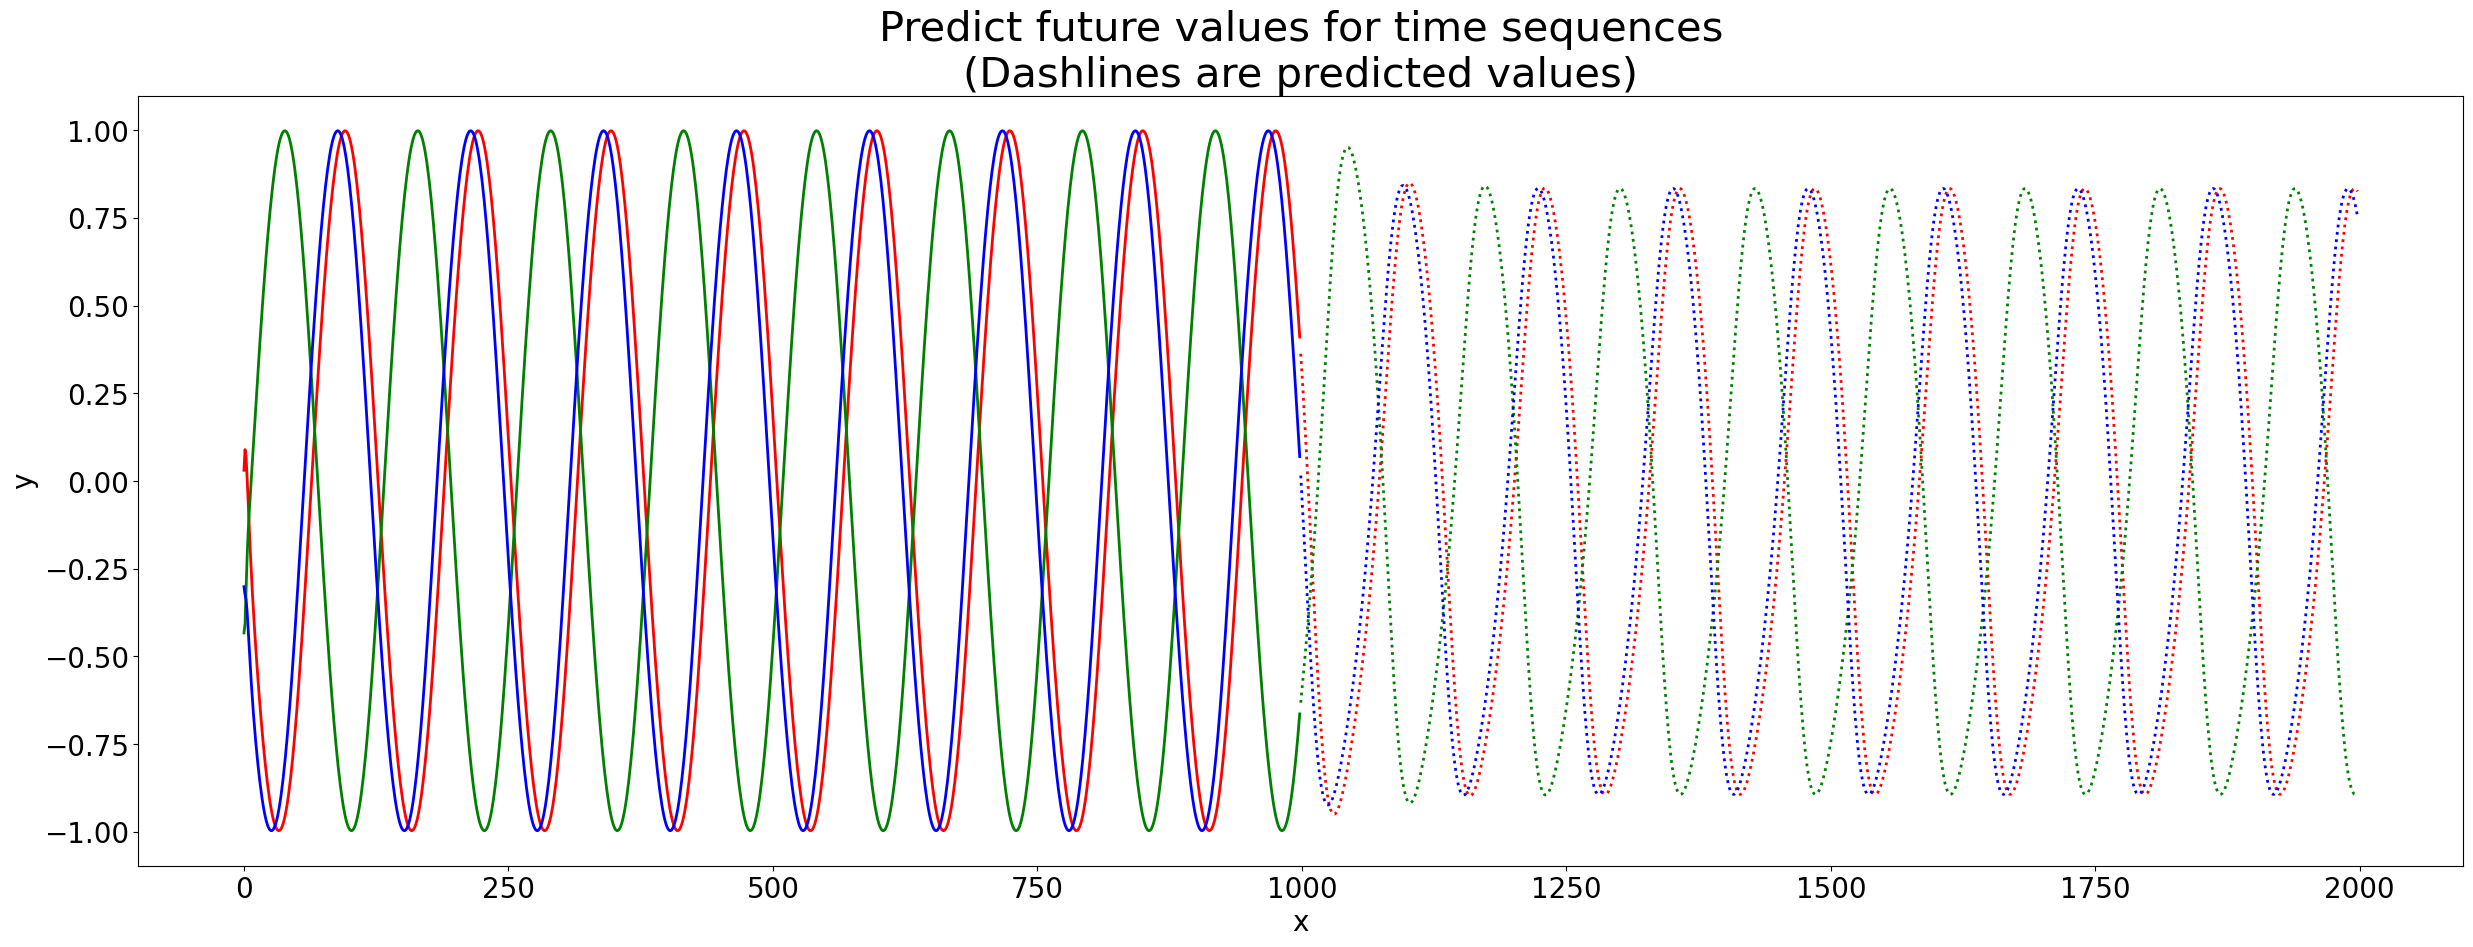

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs



# parser = argparse.ArgumentParser()
# parser.add_argument('--steps', type=int, default=15, help='steps to run')
# opt = parser.parse_args()
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train
for i in range(5):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
# draw the result
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
# plt.savefig('predict%d.pdf'%i)
# plt.close()